# Tissue Clustering


In [192]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData

In [193]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [194]:
data_path = 'C:/Users/mejas/Documents/BGI/datasets/stereoseq/SS200000135TL_D1_with_annotation.h5ad'
adata = sc.read(data_path)

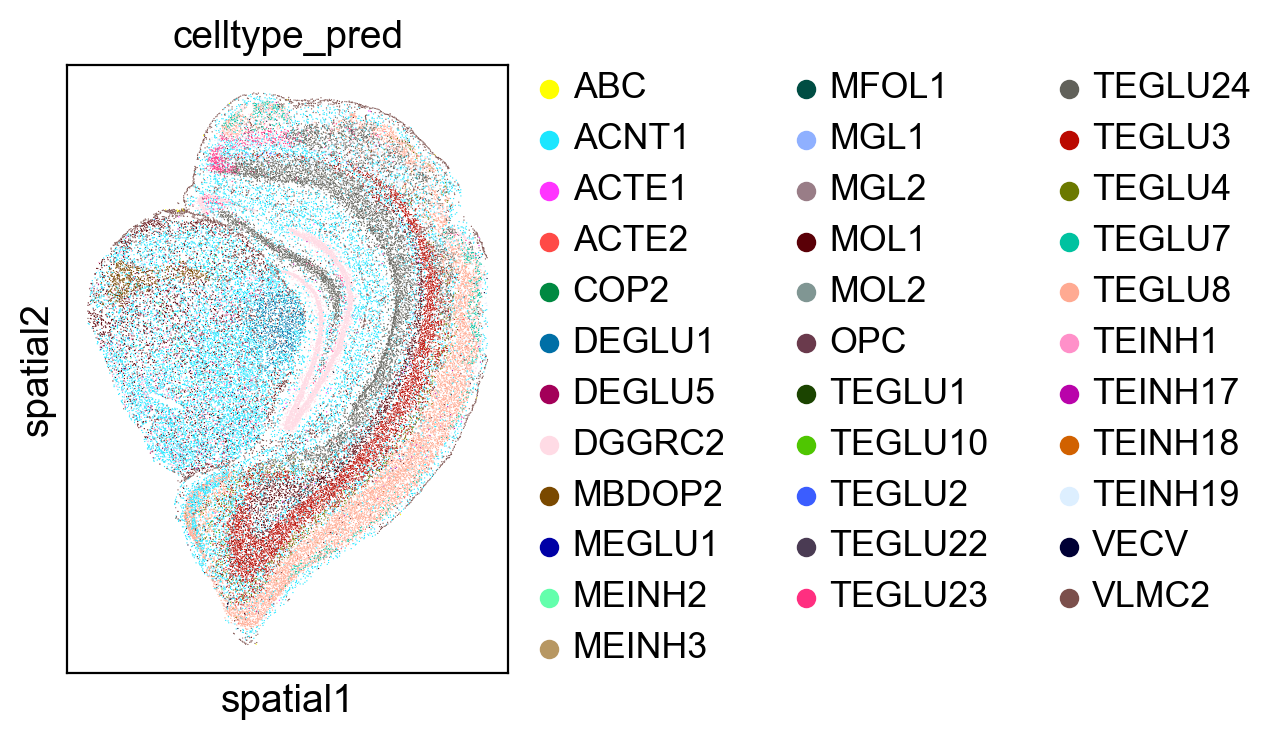

In [195]:
sc.pl.spatial(adata, color='celltype_pred', spot_size=30)

# square bin

In [196]:
def tissue_cluster(adata1, use_col, bin_size = 200, moran_thres = 0.4):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0]/bin_size).astype(int)
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1]/bin_size).astype(int)
    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {x:0 for x in tmp[use_col].cat.categories}
    ret = {}
    for x,y in tmp.groupby('x_y'):
        templete_dic = {x:0 for x in tmp[use_col].cat.categories}
        for z in y[use_col]:
            templete_dic[z]+=1
        ret[x] = templete_dic
    ret = pd.DataFrame(ret).T
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in ret.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')
    
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]
    
    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, 0.1)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])
    return tissue

tissue = tissue_cluster(adata, 'celltype_pred', bin_size = 200, moran_thres = -1)

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1470176344.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


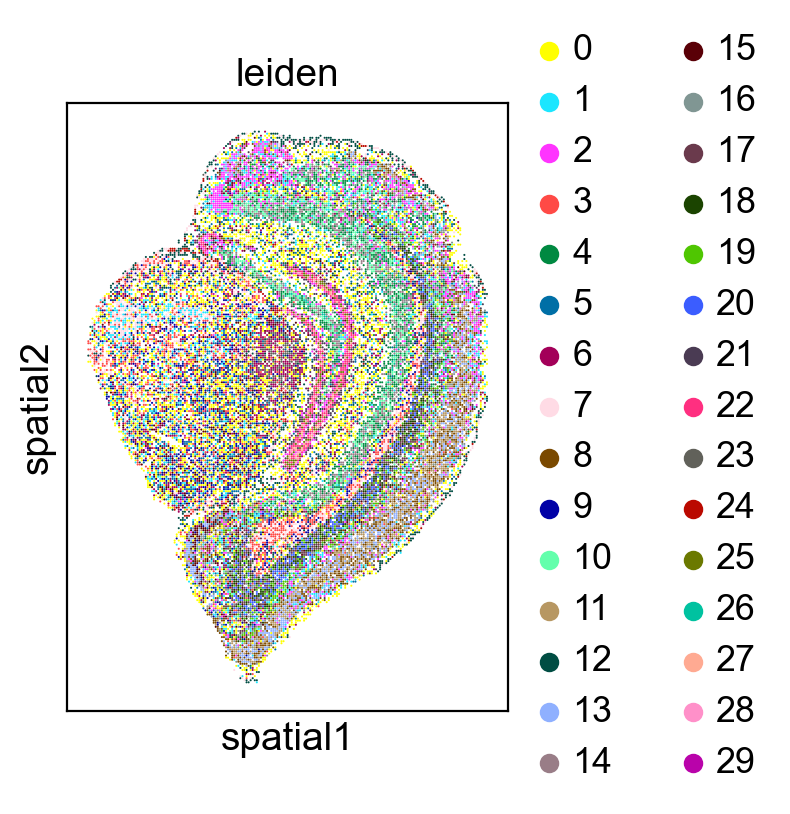

In [197]:
sc.pl.spatial(tissue, color='leiden', spot_size=1)

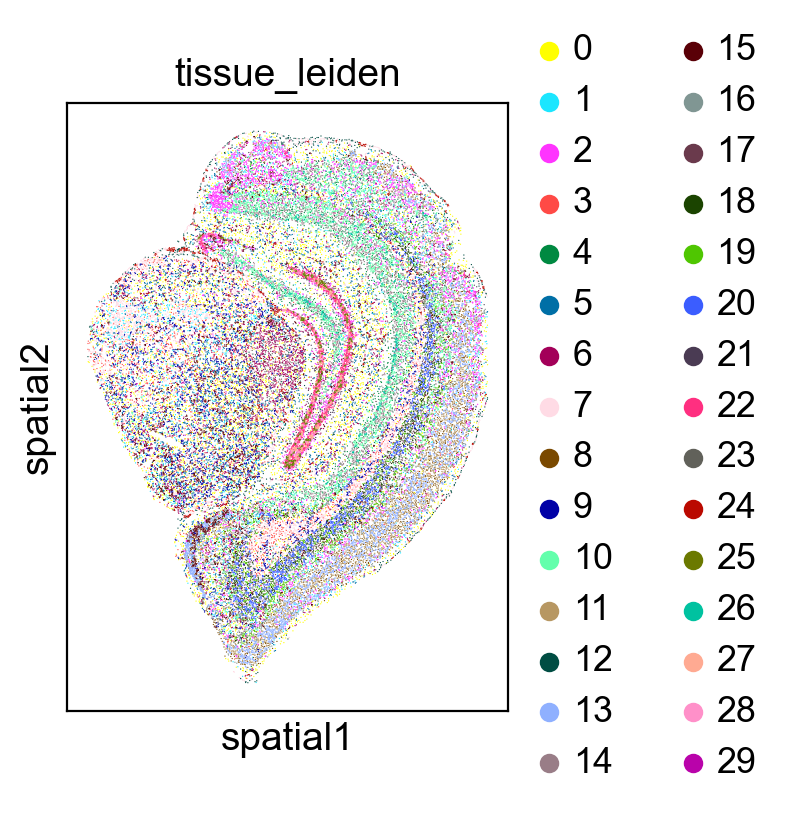

In [198]:
sc.pl.spatial(adata, color='tissue_leiden', spot_size=30)

# co-occurrence method

In [110]:
def density_calculator(stats, use_col, row, density_thred, l,r,u,d):
    left = row[1]['Centroid_X']+l*density_thred
    right = row[1]['Centroid_X']+r*density_thred
    up = row[1]['Centroid_Y']+u*density_thred
    down = row[1]['Centroid_Y']+d*density_thred
    #print(left, right, up, down)
    tmp = stats.loc[(stats['Centroid_X']<right)&(left<stats['Centroid_X'])&(stats['Centroid_Y']<up)&(down<stats['Centroid_Y'])]
    tmp = tmp.groupby(by=use_col).count()
    return list(tmp['Centroid_X'])
    

def tissue_cluster_cell_res(adata1, use_col, bin_size = 200, moran_thres = 0.0):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        tmp = density_calculator(stats,use_col, row, bin_size/2, -1,1,1,-1)
        ret.append(tmp)
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = stats[use_col].cat.categories
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    
    sc.pp.neighbors(tissue, use_rep='spatial')
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])
    return tissue

tissue = tissue_cluster_cell_res(adata, use_col='celltype_pred', bin_size = 200, moran_thres = 0.0)

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1131433871.py:26: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


<AxesSubplot:ylabel='Count'>

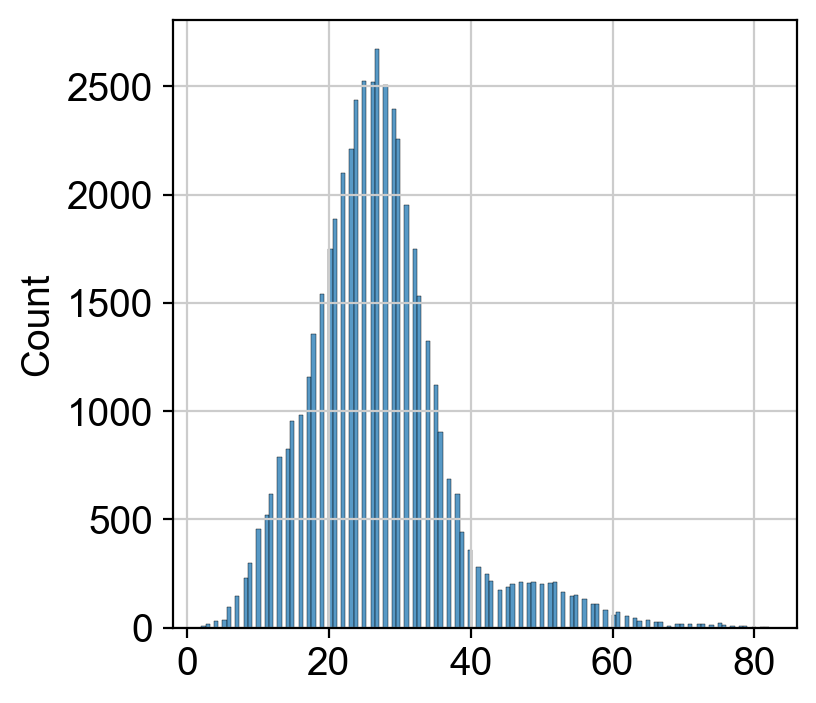

In [111]:
import seaborn as sns
sns.histplot(np.sum(tissue.X, axis=1))

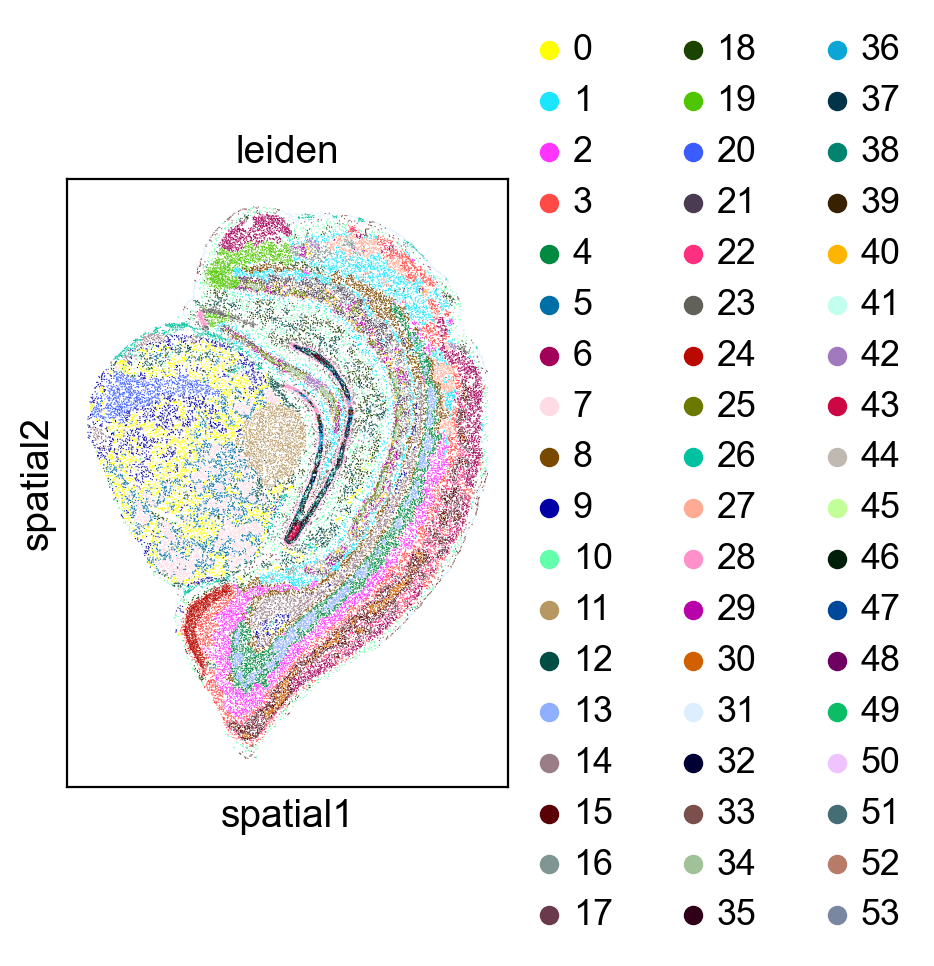

In [112]:
sc.pl.spatial(tissue, color='leiden', spot_size=30)

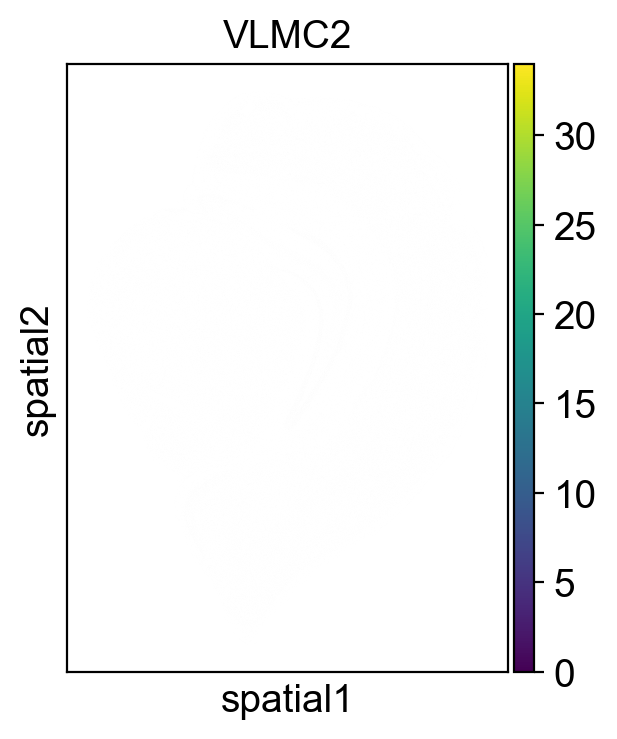

In [113]:
sc.pl.spatial(tissue, spot_size=1, color='VLMC2')

# phase position vote method

In [114]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, bias_x = 0, bias_y = 0):
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0]+bias_x)/bin_size).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1]+bias_y)/bin_size).astype(int)
    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {x:0 for x in tmp[use_col].cat.categories}
    ret = {}
    for x,y in tmp.groupby('x_y'):
        templete_dic = {x:0 for x in tmp[use_col].cat.categories}
        for z in y[use_col]:
            templete_dic[z]+=1
        ret[x] = templete_dic
    ret = pd.DataFrame(ret).T
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in ret.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')

    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata1.obs['tissue_leiden']=list(tissue.obs.loc[adata1.obs['x_y'], 'leiden'])
    #return tissue
    return list(tissue.obs.loc[adata1.obs['x_y'], 'leiden'])


In [115]:
bias = [-50,0,50]
ret = []
for i in bias:
    for j in bias:
        tmp = tissue_cluster(adata, 'celltype_pred', bias_x = i, bias_y =j)
        ret.append(tmp)

df = pd.DataFrame(ret).T

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1458474573.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)
C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1458474573.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)
C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/1458474573.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissu

In [116]:
# df = pd.read_csv('./tissue_cluster_vote_result.csv', index_col=0).T

FileNotFoundError: [Errno 2] No such file or directory: './tissue_cluster_vote_result.csv'

In [117]:
df

0   1   2   3   4   5   6   7   8
0      14  12  18  19  16  11  20  16  17
1      14   9  15  19  12  15  20  16  17
2      14  14  16  19  12  15  20  10  21
3      14  14  16  19  12  15  20  10  21
4       7   9  15  17  16  11   9  16  17
...    ..  ..  ..  ..  ..  ..  ..  ..  ..
49916  17  12  21  13  16  11  20  16  17
49917   9   9  15  13  16  11  11  16  13
49918  17   9  15  13  16  11  20  16  13
49919  14  12  21  19  16  15  20  16  17
49920  17   9  15  13  16  11  20  16  13

[49921 rows x 9 columns]

In [118]:
def compare_cluster(cluster1, cluster2):
    #n1 = cluster1.nunique()
    #n2 = cluster2.nunique()
    #if n1 > n2:
    #    cluster1, cluster2 = cluster2, cluster1 # keep cluster1 has less clusters
    df_tmp = pd.DataFrame({'c1':cluster1, 'c2':cluster2})
    ret = {}
    for i,j in df_tmp.groupby('c2'):
        ret[i]=j.groupby('c1').count()['c2'].idxmax()
    return [ret[x] for x in cluster2]



In [119]:
center_col = df.nunique().idxmin()
ret = []
for col in df:
    ret.append(compare_cluster(df[center_col], df[col]))
ret = pd.DataFrame(ret).T

In [120]:
labels = []
for row in ret.iterrows():
    tmp = list(row[1])
    labels.append(max(tmp, key=tmp.count))
    

In [121]:
adata.obs['tmp'] = labels

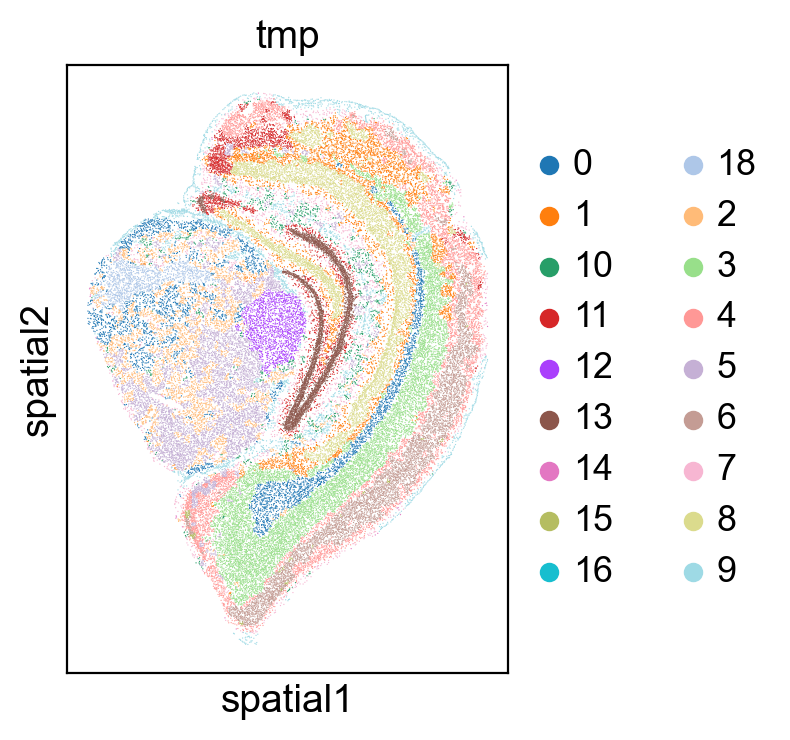

In [122]:
adata.obs['tmp'] = adata.obs['tmp'].astype('category')
sc.pl.spatial(adata, color='tmp', spot_size=30)

# Sliding window

In [186]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, sliding_step = None):

    # bin size needs to be a multiple of sliding step
    sliding_step = (bin_size/int((bin_size/sliding_step))) if sliding_step!=None else bin_size
    bin_slide_ratio = int(bin_size/sliding_step)

    # create centroids for each sliding step of windows
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0])/sliding_step).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1])/sliding_step).astype(int)
    # need to understand borders and padding
    # subwindows belonging to borders will not have a complete cell count
    x_max = adata1.obs['Centroid_X'].max()
    y_max = adata1.obs['Centroid_Y'].max()

    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {ct:0 for ct in tmp[use_col].cat.categories}
    ret = {}
    # calculate features for each subwindow
    for sw_ind, sw_data in tmp.groupby('x_y'):
        templete_dic = {ct:0 for ct in tmp[use_col].cat.categories}
        for cell in sw_data[use_col]:
            templete_dic[cell]+=1
        ret[sw_ind] = templete_dic
    # merge features by windows
    feature_matrix = {}
    for subwindow in ret.keys():
        # index of window is in the top left corner of the whole window
        feature_matrix[subwindow] = {}
        x_curr = int(subwindow.split("_")[0])
        y_curr = int(subwindow.split("_")[1])
        # count the number of subwindows participating in full window feature vec
        num_subw = 0

        for slide_x in range(0, np.min([bin_slide_ratio, x_max-x_curr+1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_max-y_curr+1])):  # starts from 1 since values with coordinates (0,0) are already written by initializing with ret[subwindow]
                if (f'{x_curr + slide_x}_{y_curr + slide_y}') in ret.keys():
                    num_subw += 1
                    feature_matrix[subwindow] = {k: 
                                                feature_matrix[subwindow].get(k, 0) + ret[f'{x_curr + slide_x}_{y_curr + slide_y}'].get(k, 0)
                                                for k in set(feature_matrix[subwindow]).union(ret[f'{x_curr + slide_x}_{y_curr + slide_y}'])}
        
        # feature_matrix[subwindow] = {k:feature_matrix[subwindow][k]/num_subw for k in feature_matrix[subwindow].keys()}

    feature_matrix = pd.DataFrame(feature_matrix).T
    tissue = AnnData(feature_matrix)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in feature_matrix.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')

    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=0.1)

    # max voting on cluster labels
    # init the new obs column
    tissue.obs['leiden_refined'] = list('x' for x in range(len(tissue.obs.index)))
    for x_curr, y_curr in tissue.obsm['spatial']:
        # index of subwindow is in the top left corner of the whole window
        subwindow_labels = {}
        for slide_x in range(0, np.min([bin_slide_ratio, x_curr + 1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_curr + 1])):
                # check if location exist (spatial area is not complete)
                if (f'{x_curr - slide_x}_{y_curr - slide_y}') in tissue.obs.index:
                    new_value = tissue.obs.loc[f'{x_curr - slide_x}_{y_curr - slide_y}', 'leiden']
                    subwindow_labels[new_value] = subwindow_labels[new_value] + 1 if new_value in subwindow_labels.keys() else 1
        
        # max vote
        # max vote should be saved in a new obs column so that it does not have diagonal effect on
        # other labels during refinment
        tissue.obs['leiden_refined'][f'{x_curr}_{y_curr}'] = max(subwindow_labels, key=subwindow_labels.get)


    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata.obs['tissue_sliding_leiden'] = list(tissue.obs.loc[adata.obs['x_y'], 'leiden_refined'])
    #return tissue
    return tissue

In [187]:
adata.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
4.0                    166                 5.117994         304.0   
5.0                    115                 4.753590         213.0   
9.0                    176                 5.176150         339.0   
10.0                   120                 4.795791         242.0   
13.0                   161                 5.087596         301.0   
...                    ...                      ...           ...   
55899.0                196                 5.283204         470.0   
55900.0                177                 5.181784         335.0   
55901.0                172                 5.153292         362.0   
55902.0                237                 5.472271         572.0   
55903.0                222                 5.407172         449.0   

         log1p_total_counts  pct_counts_in_top_50_genes  \
4.0                5.720312                   59.210526   
5.0                5.365976                   69.483568   
9.0                5.828946                   57.817109   
10.0               5.493062                   70.247934   
13.0               5.710427                   56.810631   
...                     ...                         ...   
55899.0            6.154858                   61.702128   
55900.0            5.817111                   57.014925   
55901.0            5.894403                   60.497238   
55902.0            6.350886                   55.594406   
55903.0            6.109248                   51.447661   

         pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
4.0                        78.289474                   100.000000   
5.0                        92.957746                   100.000000   
9.0                        77.581121                   100.000000   
10.0                       91.735537                   100.000000   
13.0                       79.734219                   100.000000   
...                              ...                          ...   
55899.0                    79.574468                   100.000000   
55900.0                    77.014925                   100.000000   
55901.0                    80.110497                   100.000000   
55902.0                    75.000000                    93.531469   
55903.0                    72.828508                    95.100223   

         pct_counts_in_top_500_genes  total_counts_mt  log1p_total_counts_mt  \
4.0                            100.0              5.0               1.791759   
5.0                            100.0             14.0               2.708050   
9.0                            100.0              7.0               2.079442   
10.0                           100.0              5.0               1.791759   
13.0                           100.0              8.0               2.197225   
...                              ...              ...                    ...   
55899.0                        100.0              7.0               2.079442   
55900.0                        100.0              7.0               2.079442   
55901.0                        100.0              4.0               1.609438   
55902.0                        100.0              8.0               2.197225   
55903.0                        100.0              9.0               2.302585   

         ...  psuedo_class  celltype_pred morpho_featureID leiden  Centroid_X  \
4.0      ...         VLMC2          VLMC2                2      8         154   
5.0      ...           ABC          VLMC2                3      8         152   
9.0      ...         VLMC2          VLMC2                7      8         157   
10.0     ...       TEGLU11          ACNT1                8      6         157   
13.0     ...         VLMC2          VLMC2               11      8         153   
...      ...           ...            ...              ...    ...         ...   
55899.0  ...         VLMC2          VLMC2            55449      8         152   
55900.0  ...          PVM1       

C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/4181796660.py:46: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(feature_matrix)
C:\Users\mejas\AppData\Local\Temp/ipykernel_22244/4181796660.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue.obs['leiden_refined'][f'{x_curr}_{y_curr}'] = max(subwindow_labels, key=subwindow_labels.get)


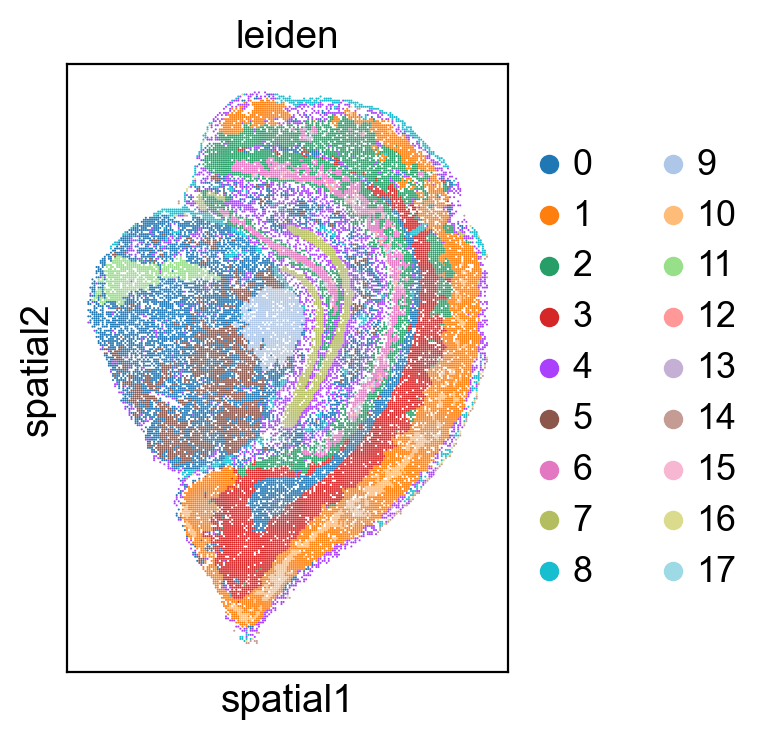

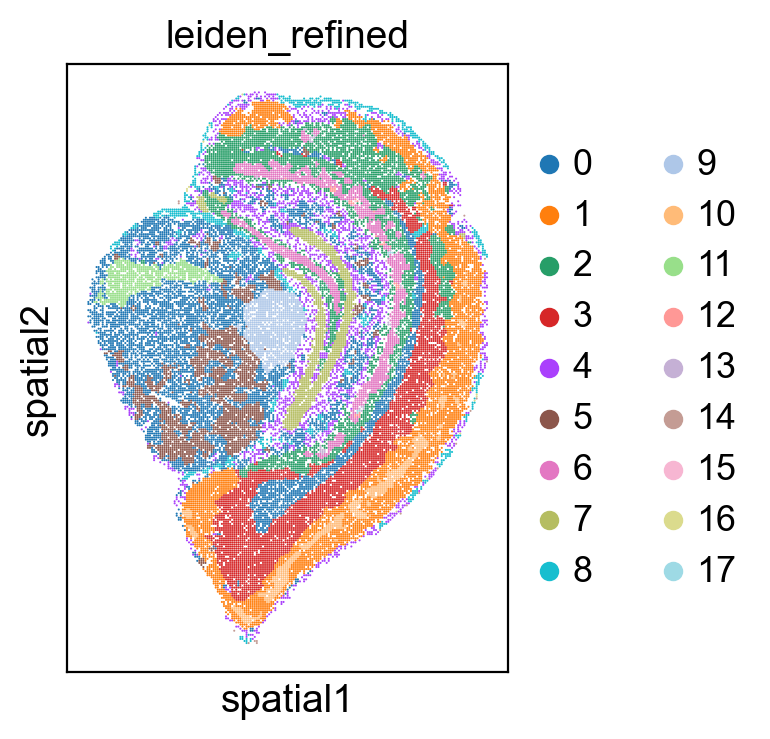

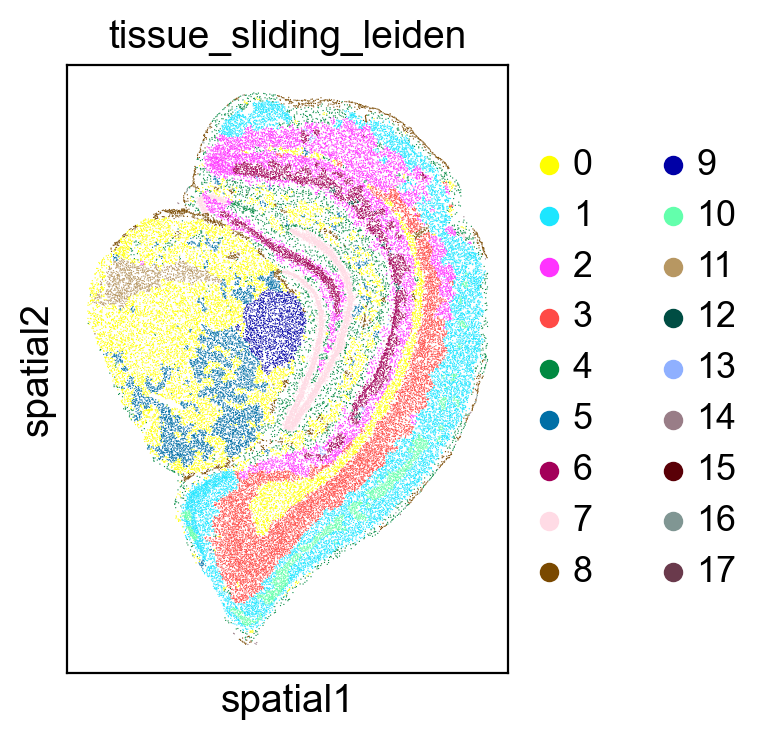

In [188]:
tissue = tissue_cluster(adata1=adata, use_col='celltype_pred', bin_size=150, moran_thres=-1, sliding_step=50)

In [ ]:
# plot initial clustering for each window
sc.pl.spatial(tissue, color='leiden', spot_size=1)
# plot clustering after majority voting for each subwindow
sc.pl.spatial(tissue, color='leiden_refined', spot_size=1)

In [ ]:
# plot final clustering in cell resolution
sc.pl.spatial(adata, color='tissue_sliding_leiden', spot_size=30)

## Cell community statistics

In [189]:
# extract information on leiden clustering labels and cell types to create cell communities statistics
clustering_labels = 'tissue_sliding_leiden'
cell_types_col = 'celltype_pred'
cell_types_communities = adata.obs[[clustering_labels, cell_types_col]]

stats_table = {}
# calculate cell type mixtures for every cluster
for label, cluster_data in cell_types_communities.groupby(clustering_labels):
    cell_type_dict = {ct:0 for ct in cell_types_communities[cell_types_col].cat.categories}
    for cell in cluster_data[cell_types_col]:
        cell_type_dict[cell]+=1
    total_cluster_cells = sum(cell_type_dict.values())
    stats_table[label] = {ct:cell_type_dict[ct]/total_cluster_cells for ct in cell_type_dict.keys()}

stats = pd.DataFrame(stats_table).T



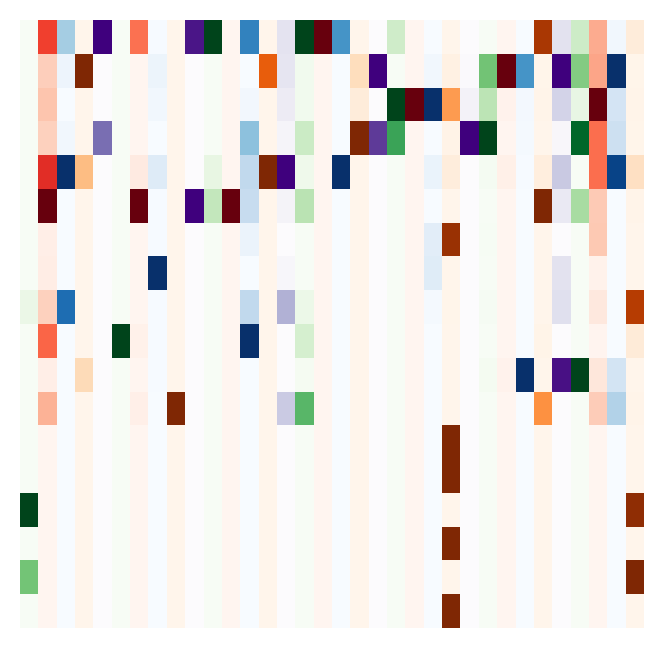

In [190]:
from matplotlib import pyplot as plt
from itertools import cycle

ncols = len(stats.columns)
fig, axes = plt.subplots(ncols=ncols)

# no space between columns
fig.subplots_adjust(wspace=0)

# put colormaps of your choice in a list:
cmap_cycle = cycle(['Greens', 'Reds', 'Blues', 'Oranges', 'Purples'])

for i, ax in enumerate(axes):
    sns.heatmap(pd.DataFrame(stats.iloc[:, i]), cbar=False, ax=ax, cmap=cmap_cycle.__next__(), xticklabels=False, yticklabels=False)

plt.show()

In [191]:
stats

ABC     ACNT1     ACTE1     ACTE2      COP2    DEGLU1    DEGLU5  \
0   0.000000  0.471792  0.001615  0.000000  0.000431  0.000646  0.013028   
1   0.000000  0.142540  0.000234  0.003271  0.000000  0.000000  0.000000   
2   0.000000  0.166236  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.136135  0.000143  0.000000  0.000287  0.000000  0.000000   
4   0.000350  0.516783  0.004545  0.001049  0.000000  0.000000  0.001748   
5   0.000000  0.765724  0.000000  0.000000  0.000000  0.000255  0.027247   
6   0.000000  0.031997  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.038610  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.008345  0.136996  0.003477  0.000000  0.000000  0.000695  0.000000   
9   0.000000  0.393625  0.000000  0.000000  0.000000  0.452187  0.000741   
10  0.000000  0.030960  0.000000  0.000619  0.000000  0.000000  0.000000   
11  0.000000  0.213983  0.000000  0.000000  0.000000  0.000000  0.001059   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.100000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.050000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      DGGRC2    MBDOP2    MEGLU1  ...    TEGLU3    TEGLU4    TEGLU7    TEGLU8  \
0   0.004414  0.001723  0.001184  ...  0.001615  0.000000  0.000000  0.000323   
1   0.052576  0.000000  0.000000  ...  0.011684  0.024886  0.064377  0.574600   
2   0.030391  0.000000  0.000000  ...  0.051360  0.014132  0.001216  0.020666   
3   0.000717  0.000000  0.000000  ...  0.601779  0.049204  0.000000  0.017358   
4   0.120629  0.000000  0.000000  ...  0.000699  0.001049  0.002098  0.006643   
5   0.007130  0.000255  0.001273  ...  0.000000  0.000000  0.000000  0.000509   
6   0.007111  0.000000  0.000000  ...  0.001616  0.000323  0.000000  0.000000   
7   0.944337  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
8   0.004868  0.000000  0.000000  ...  0.004172  0.000695  0.000000  0.001391   
9   0.006672  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
10  0.004334  0.000000  0.000000  ...  0.001238  0.001238  0.001238  0.931889   
11  0.000000  0.533898  0.000000  ...  0.001059  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

      TEINH1   TEINH17   TEINH18   TEINH19      VECV     VLMC2  
0   0.047158  0.000646  0.000969  0.051249  0.000108  0.073105  
1   0.000234  0.003271  0.001986  0.054446  0.003388  0.005374  
2   0.000456  0.000912  0.000456  0.170643  0.000608  0.007598  
3   0.000143  0.000143  0.003873  0.083202  0.000717  0.005021  
4   0.003147  0.001049  0.000000  0.082867  0.003147  0.150699  
5   0.054495  0.000509  0.001528  0.034123  0.000000  0.009677  
6   0.000000  0.000000  0.000000  0.035229  0.000000  0.000646  
7   0.000000  0.000644  0.000000  0.003861  0.000000  0.000322  
8   0.000000  0.000695  0.000000  0.013213  0.000000  0.792072  
9   0.000741  0.000000  0.000000  0.000741  0.000000  0.079318  
10  0.000000  0.003096  0.004334  0.014861  0.000619  0.000000  
11  0.026483  0.000000  0.000000  0.032839  0.001059  0.010593  
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  0.000000  0.000